# Masksembles for probablistic regression

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from scipy.stats import norm

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense

from masksembles.keras import Masksembles1D

## Usecase: linear RUL with masksembles

**Define the data function and parameter limits**

In [3]:
# Define linear function
def func(x, a, c, noise_amp = 0):
    y = a*x + c
    y = y + noise_amp * np.random.randn(len(x))
    return y

**Previous model (Deterministic)**

In [4]:
model = Sequential()
model.add(Dense(64, input_dim=100, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')

2024-11-07 15:45:09.654069: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-07 15:45:09.654210: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (GTCWK05): /proc/driver/nvidia/version does not exist
2024-11-07 15:45:09.657902: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**New model with masksembles**

In [5]:
np.random.seed(2049)

def create_dataset(x, n_training_obs=1000):

    x = np.arange(0,10,0.1)
    a_range = (0, 2)
    c_range = (0, 10)
    noise_range = (0,5)

    a_list = np.random.rand(n_training_obs)*(a_range[1] - a_range[0]) + a_range[0]
    c_list = np.random.rand(n_training_obs)*(c_range[1] - c_range[0]) + c_range[0]
    noise_list = np.random.rand(n_training_obs)*(noise_range[1] - noise_range[0]) + noise_range[0]

    targets = np.array(list(zip(a_list,c_list)))
    targets_with_noise = np.array(list(zip(a_list,c_list,noise_list)))
    features = np.array([func(x,a,c,noise) for a, c, noise in targets_with_noise])

    return features, targets, noise_list

x = np.arange(0,10,0.1)
features, targets, noise_list = create_dataset(x, 10000)

In [10]:
batch_size = 100

input_layer = Input(shape=(100,))
layer_x = Dense(100, activation='relu')(input_layer)
layer_x = Masksembles1D(100, 2.0)(layer_x)
layer_x = Dense(50, activation='relu')(layer_x)
layer_x = Masksembles1D(100, 2.0)(layer_x)
layer_x = Dense(25, activation='relu')(layer_x)
layer_x = Masksembles1D(100, 2.0)(layer_x)
output_layer = Dense(2, activation='linear')(layer_x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
masksembles1d_3 (Masksembles (None, 100)               10000     
_________________________________________________________________
dense_9 (Dense)              (None, 50)                5050      
_________________________________________________________________
masksembles1d_4 (Masksembles (None, 50)                5000      
_________________________________________________________________
dense_10 (Dense)             (None, 25)                1275      
_________________________________________________________________
masksembles1d_5 (Masksembles (None, 25)                2500

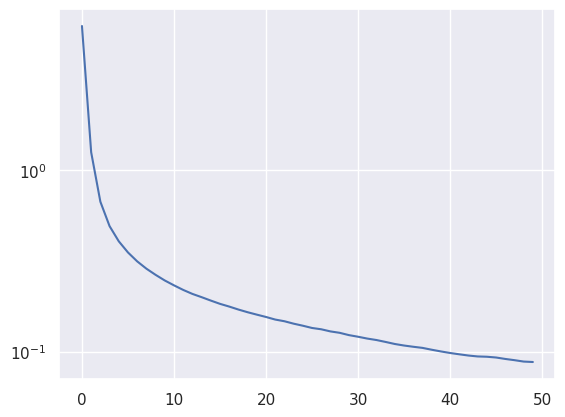

CPU times: user 11.8 s, sys: 3.36 s, total: 15.2 s
Wall time: 7.76 s


In [12]:
%%time
history = model.fit(features, targets, epochs=50, batch_size=batch_size, verbose=0, shuffle=False)

plt.plot(history.history['loss'])
plt.yscale('log')
plt.show()

### Test the model

In [13]:
test_features = np.array([[1,2,3],[4,5,6]])
np.repeat(test_features, 2, axis=0)

array([[1, 2, 3],
       [1, 2, 3],
       [4, 5, 6],
       [4, 5, 6]])

In [23]:
np.random.seed(2050)
features, targets, noise_list = create_dataset(x, 10000)
feature_stack = np.repeat(features, batch_size, axis=0)

y_pred = model.predict(feature_stack, batch_size=batch_size)
y_pred.shape

(1000000, 2)

In [24]:
y_pred = y_pred.reshape(-1, batch_size, 2)
y_pred.shape

(10000, 100, 2)

In [25]:
y_pred[0][:10]

array([[ 0.5637736 ,  8.934168  ],
       [ 0.7374872 ,  7.83128   ],
       [ 0.64196175,  9.124114  ],
       [ 0.69888806,  7.8593545 ],
       [ 0.9409773 ,  7.179697  ],
       [ 0.78207994,  8.619821  ],
       [ 0.64379394,  8.117769  ],
       [-0.21939012,  8.948881  ],
       [ 0.03724083,  9.582032  ],
       [ 0.5080905 ,  7.72875   ]], dtype=float32)

In [26]:
y_pred[1][:10]

array([[1.5002344, 5.793669 ],
       [1.5959406, 6.0261073],
       [1.9916222, 5.633622 ],
       [1.6344538, 4.581557 ],
       [1.0114212, 6.527238 ],
       [1.879704 , 4.9861455],
       [1.7266614, 5.631295 ],
       [1.361392 , 5.8492055],
       [1.9109952, 5.375443 ],
       [1.2917123, 4.1475377]], dtype=float32)

In [27]:
a_mean = y_pred[:,:,0].mean(axis=1)
a_std = y_pred[:,:,0].std(axis=1)

c_mean = y_pred[:,:,1].mean(axis=1)
c_std = y_pred[:,:,1].std(axis=1)

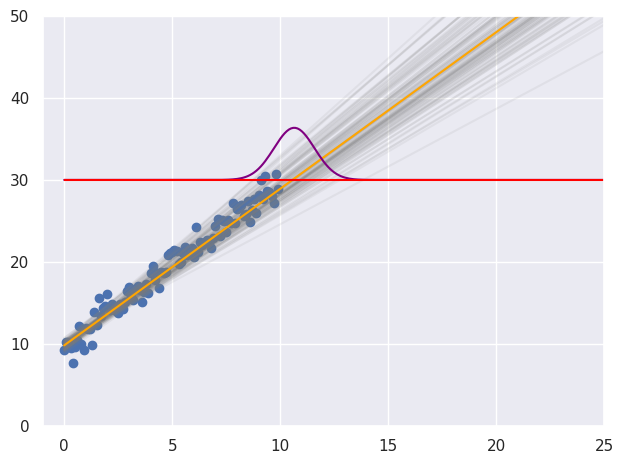

In [31]:
idx = 3

limit = 30
x30 = np.arange(0,30,0.1)
rul_list = []


for a, c in y_pred[idx]:
    y_pred_idx = func(x30, a, c)
    plt.plot(x30, y_pred_idx, color='grey', alpha=0.1)
    idx_rul = np.abs(y_pred_idx - limit).argmin()
    rul = x30[idx_rul]
    rul_list.append(rul)

y_pred_mean = func(x30, a_mean[idx], c_mean[idx])
plt.plot(x30, y_pred_mean, color='orange')

rul_list = np.array(rul_list)
rul_mean = rul_list.mean()
rul_std = rul_list.std()
rul_pdf = norm.pdf(x30, rul_mean, rul_std)
plt.plot(x30, (rul_pdf*15)+30, color='purple')

plt.hlines(limit, 0, 30, color='red')
plt.scatter(x, features[idx])

plt.xlim(-1,25)
plt.ylim(0,50)
plt.tight_layout()
plt.savefig('images/5.1 test sample1.png',dpi=150)
plt.show()

## Make the model more complex

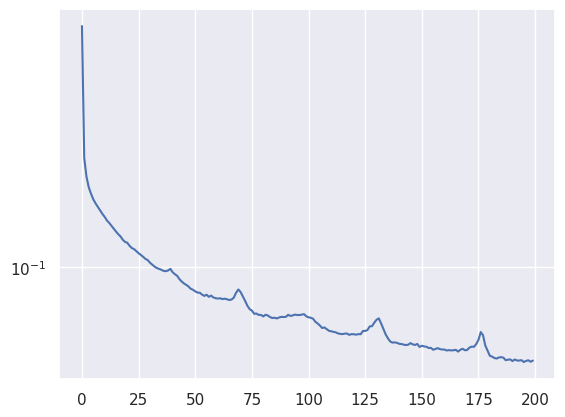

CPU times: user 5min 8s, sys: 1min 24s, total: 6min 33s
Wall time: 2min 58s


In [32]:
%%time

x = np.arange(0,10,0.1)
features, targets, noise_list = create_dataset(x, 50000)

batch_size = 100

input_layer = Input(shape=(100,))
layer_x = Dense(200, activation='relu')(input_layer)
layer_x = Masksembles1D(100, 2.0)(layer_x)
layer_x = Dense(100, activation='relu')(layer_x)
layer_x = Masksembles1D(100, 2.0)(layer_x)
layer_x = Dense(50, activation='relu')(layer_x)
layer_x = Masksembles1D(100, 2.0)(layer_x)
output_layer = Dense(2, activation='linear')(layer_x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(features, targets, epochs=200, batch_size=batch_size, verbose=0, shuffle=False)

plt.plot(history.history['loss'])
plt.yscale('log')
plt.show()

**Test the model**

In [33]:
%%time

np.random.seed(2050)

features, targets, noise_list = create_dataset(x, 10000)
feature_stack = np.repeat(features, batch_size, axis=0)

y_pred = model.predict(feature_stack, batch_size=batch_size)
y_pred = y_pred.reshape(-1, batch_size, 2)

a_mean = y_pred[:,:,0].mean(axis=1)
a_std = y_pred[:,:,0].std(axis=1)

c_mean = y_pred[:,:,1].mean(axis=1)
c_std = y_pred[:,:,1].std(axis=1)

CPU times: user 12.1 s, sys: 3.28 s, total: 15.4 s
Wall time: 11.1 s


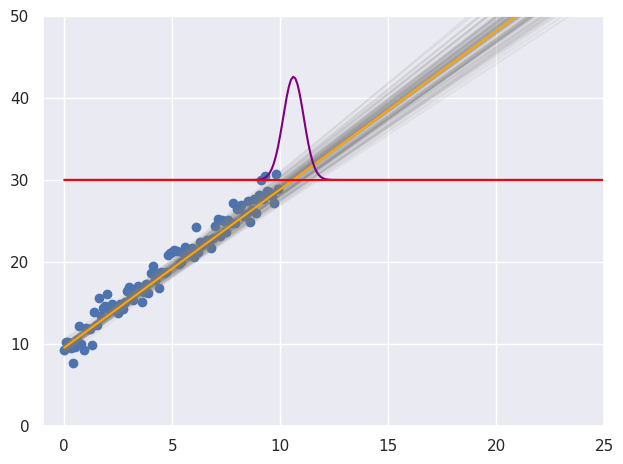

In [34]:
idx = 3

limit = 30
x30 = np.arange(0,30,0.1)
rul_list = []


for a, c in y_pred[idx]:
    y_pred_idx = func(x30, a, c)
    plt.plot(x30, y_pred_idx, color='grey', alpha=0.1)
    idx_rul = np.abs(y_pred_idx - limit).argmin()
    rul = x30[idx_rul]
    rul_list.append(rul)

y_pred_mean = func(x30, a_mean[idx], c_mean[idx])
plt.plot(x30, y_pred_mean, color='orange')

rul_list = np.array(rul_list)
rul_mean = rul_list.mean()
rul_std = rul_list.std()
rul_pdf = norm.pdf(x30, rul_mean, rul_std)
plt.plot(x30, (rul_pdf*15)+30, color='purple')

plt.hlines(limit, 0, 30, color='red')
plt.scatter(x, features[idx])

plt.xlim(-1,25)
plt.ylim(0,50)
plt.tight_layout()
plt.savefig('images/5.2 test sample2.png',dpi=150)
plt.show()